<a href="https://colab.research.google.com/github/Joeychen80627/CSE598Project/blob/main/CSCA_5632_Unsupervised_Algorithms_in_Machine_Learning_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integrated Energy System Multi-Load Anomaly Detection**

## **Step 1 : Gather data, determine the method of data collection and provenance of the data (3 points)**

In [79]:
!pip install vmdpy --no-cache-dir

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import vmdpy
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.cluster import KMeans
from numpy.linalg import svd, norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster




##1. **Data Sources and Description**
  *  Data Sources
    *  Energy Data:
      *  Collected from the electricity usage units of the company’s internal buildings (including factories). (Data file: energy_data.xlsx)
    *  Meteorological Data:
      *  Acquired from the Central Weather Bureau of the Ministry of Transportation and Communications, Taiwan, providing parameters such as Temperature, Dew_Point, Relative_Humidity, Wind_Speed, Solar_Zenith_Angle, and Pressure.
    *  APA Citation:
      *  Central Weather Bureau. (2023). Central Weather Bureau Meteorological Data [Data set]. Ministry of Transportation and Communications, Taiwan. Retrieved from https://www.cwb.gov.tw/
    *  Data Description
      *  Time Range: January 1, 2023 – January 31, 2023
    *  Data Size:
      *  Approximately 744 records (recorded hourly), with each record containing more than 20 features (both numerical and categorical).
    *  Data Types:
      *  Numerical: e.g., KW, CHWTON, HTmmBTU, Temperature, Relative_Humidity, etc.
      *  Categorical: e.g., Cloud_Type, Season, Daylight_Duration, etc.

In [81]:
file_path = '/content/drive/MyDrive/CU/Machine Learning: Theory and Hands-On Practice with Python Specialization/Machine Learning: Theory & Hands-On Practice with Python/energy_data.xlsx'
df_raw = pd.read_excel(file_path)
df = df_raw.copy()

## **Identify an Unsupervised Learning Problem (6 points)**

## 2.  **Project Theme and Overview**
  *   **Project Description**

      This project aims to detect anomalies in various load statuses within an integrated energy system—specifically, electric load, cooling load, and heating load—to assist enterprises in optimizing energy dispatch, improving system reliability, and reducing carbon emissions.
      Data sources include electricity usage data from multiple buildings (including factories) collected hourly over a given period (e.g., January 2023), together with meteorological data from the Central Weather Bureau of the Ministry of Transportation and Communications, Taiwan. Meteorological parameters include temperature, dew point, relative humidity, wind speed, solar zenith angle, and pressure. Additional derived features (such as season and daylight duration) are also incorporated to comprehensively characterize energy usage.
  *   **Learning/Algorithm and Task Types**
      *   Learning Type: Unsupervised Learning for anomaly detection
      *   Task Type: Multi-load anomaly detection
          *  Instead of predicting binary load statuses, the focus here is to detect abnormal behavior in the continuous load signals.
      *   Methodology:
          *  The continuous energy load values (KW, CHWTON, HTmmBTU) are first processed using Variational Mode Decomposition (VMD) to extract intrinsic mode functions (IMFs) that capture different frequency components of the load signals.
          *  These VMD features are then combined with auxiliary meteorological and time-related factors to form multi-dimensional feature spaces for each load type.
          *  Hierarchical clustering and Singular Value Decomposition (SVD) are applied for anomaly detection:
            1.  Hierarchical clustering is used to identify clusters in the load data.
            2.  SVD is used not only for dimensionality reduction but also to compute reconstruction errors. A high reconstruction error indicates that the sample deviates from the dominant patterns and is considered anomalous.



##3.  **Project Goals and Motivation**
  *  Project Goals
      *  Anomaly Detection:
        *  Identify abnormal operating conditions in electric load, cooling load, and heating load. Abnormalities may indicate equipment faults, sensor errors, or unusual operating conditions.
      *  Key Factor Analysis:
        *   Detect the key factors (e.g., meteorological parameters, time variables) that influence energy loads and correlate with abnormal behavior.
      *  Support Energy Optimization:
        *  Early detection of anomalies allows enterprises to adjust energy dispatch strategies in advance, optimize load management, and ultimately reduce energy waste and carbon emissions.
  *  Motivation and Significance
      *  Energy Efficiency and Carbon Reduction:
        *  With the growing emphasis on carbon reduction, early anomaly detection enables proactive adjustments to energy dispatch, reducing both energy waste and carbon emissions.
      *  System Reliability:
        *  Integrated energy systems consist of multiple subsystems (electricity, cooling, heating, natural gas, etc.). Detecting anomalies in any subsystem helps prevent potential cascading failures and supports more robust system operation.
      *  Data-Driven Decision Making:
        *  By leveraging advanced data analytics techniques (VMD, clustering, SVD), enterprises can obtain deeper insights into the underlying load patterns and abnormal events, providing a strong basis for energy management strategies.



## **Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (26 points)**

## **4. Data Cleaning and Preprocessing**

###**4-1 Unit conversions and Define target variables & influencing features**
*  First, convert the units to kW. Since cooling and heating loads use different units, they need to be converted accordingly.
*  To detect anomalies in multi-load conditions, unnecessary features are removed in advance, as the analysis will later incorporate VMD, which captures time-series relationships. However, the selection of features to remove is an interesting topic in itself, and I hope to explore it further in the future.
*  The remaining data is divided into target variables and influencing factors.

In [82]:
# Unit conversions
ton_to_kw = 3.51685
mmBTU_to_kw = 293.07
if 'CHWTON' in df.columns:
    df['CHWTON'] *= ton_to_kw
if 'HTmmBTU' in df.columns:
    df['HTmmBTU'] *= mmBTU_to_kw

# Drop redundant features
redundant_features = [
    'KW_Houses', 'KWlightbulbs', 'KWgalsgas',
    'CHWTON_Houses', 'CHWTONlightbulbs', 'CHWTONgalsgas',
    'HTmmBTU_Houses', 'HTmmBTUlightbulbs', 'HTmmBTUgalsgas',
    'Totallightbulbs', 'Totalgalsgas', 'KWS', 'Combined_mmBTU',
    'Combined_Tons_Carbon', 'GHG', 'Year', 'Total_Houses',
    'day off'
]
df.drop(columns=redundant_features, errors='ignore', inplace=True)

# Define target variables and influencing features
target_vars = ['KW', 'CHWTON', 'HTmmBTU']
influencing_features = [col for col in df.columns if col not in target_vars]


### **4-2 Heatmap of Correlation Matrix**
  *  First, calculate the correlation coefficients and plot a heatmap.
  *  Then, for electric load, cooling load, and heating load, respectively, remove features with a correlation below 0.1 while retaining their respective features.

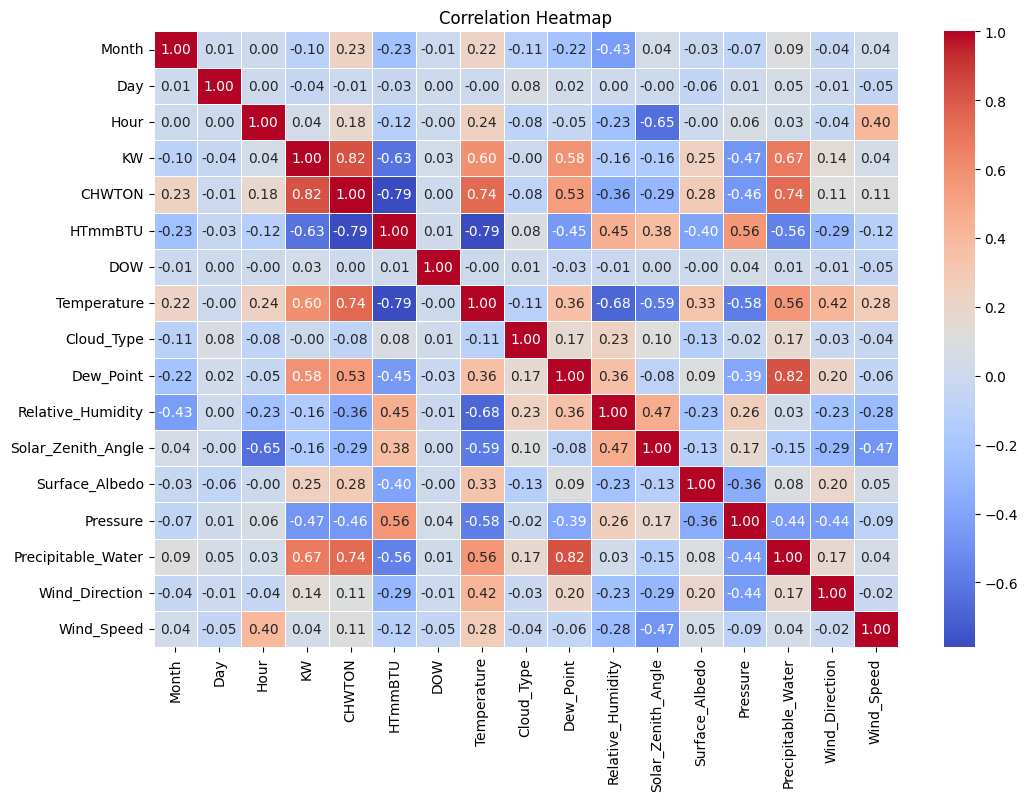

Selected features for KW: ['KW', 'CHWTON', 'Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction']
Selected features for CHWTON: ['Month', 'Hour', 'KW', 'CHWTON', 'Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction', 'Wind_Speed']
Selected features for HTmmBTU: ['HTmmBTU', 'Relative_Humidity', 'Solar_Zenith_Angle', 'Pressure']
All merged selected features: ['Precipitable_Water', 'Surface_Albedo', 'Solar_Zenith_Angle', 'KW', 'Hour', 'Wind_Speed', 'Month', 'Wind_Direction', 'Pressure', 'CHWTON', 'Dew_Point', 'Relative_Humidity', 'Temperature', 'HTmmBTU']


In [83]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Use a set to store all selected features to avoid duplicates
selected_features_all = set()

for target in target_vars:
    # Retrieve the correlation coefficients for the target variable and select features with a correlation greater than 0.1 (including the target variable itself)
    features = corr_matrix[target][corr_matrix[target] > 0.1].index.tolist()
    print(f"Selected features for {target}:", features)
    selected_features_all.update(features)

# Convert the set to a list and create a new DataFrame based on this list
selected_features_all = list(selected_features_all)
df_selected = df[selected_features_all].copy()

print("All merged selected features:", selected_features_all)


## **4-3 Define VMD and MSRE of VMD**
*  First, let's introduce **VMD (Variational Mode Decomposition)**. Since the goal is to identify anomalies in electric load, chilled load, and thermal load, VMD can be used to decompose the signals into different modes, allowing for a more detailed detection of abnormal noise.

*  For now, we will not explain the parameters in detail. In short, the K value determines the number of Intrinsic Mode Functions (IMFs). It is essential to determine the optimal K values for these three load types.

To achieve this, we calculate the Mean Square Reconstruction Error (MSRE) for different K values, then perform VMD decomposition on the signals and visualize the results.

In [84]:
# Common Parameter Definitions
alpha = 2000
tau = 0
DC = 0
init = 1
tol = 1e-7
K_values = range(1, 11)
target_vars = ['KW', 'CHWTON', 'HTmmBTU']

# Function Definitions: Compute MSRE
def compute_msre_for_signal(signal, K_values, alpha, tau, DC, init, tol):
    msre_list = []
    for K in K_values:
        # Perform VMD decomposition, returning u (modes), u_hat (frequency domain), omega (center frequencies)
        u, u_hat, omega = vmdpy.VMD(signal, alpha, tau, K, DC, init, tol)
        # Reconstruct the signal by summing all modes
        reconstructed_signal = np.sum(u, axis=0)
        # Compute Mean Square Reconstruction Error (MSRE) using L2 norm
        msre = (norm(signal - reconstructed_signal, 2)**2) / (norm(signal, 2)**2)
        msre_list.append(msre)
    return msre_list


# Function Definition: Perform VMD and Plot Results
def perform_and_plot_vmd(signal, signal_name, K):
    # Perform VMD decomposition
    u, u_hat, omega = vmdpy.VMD(signal, alpha, tau, K, DC, init, tol)
    # Plot VMD modes
    plt.figure(figsize=(12, 8))
    for i in range(K):
        plt.subplot(K, 1, i+1)
        plt.plot(u[i, :])
        plt.ylabel(f"Mode {i+1}")
        if i == 0:
            plt.title(f"{signal_name} - VMD Decomposition (K = {K})")
    plt.tight_layout()
    plt.show()
    return u, u_hat, omega



According to the plots, as the K value increases, MSRE changes accordingly. However, when MSRE stabilizes, increasing K further becomes meaningless.

Electric loads:  Optimal K value = 4

heating loads: Optimal K value = 3

cooling load: Optimal K value = 3

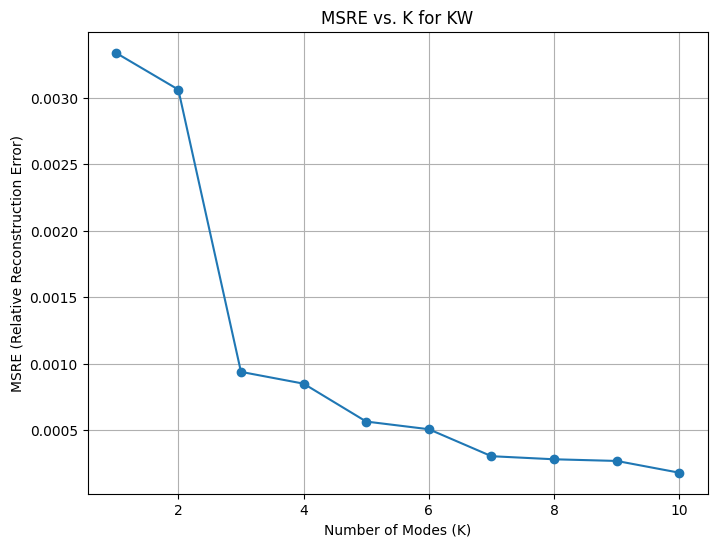

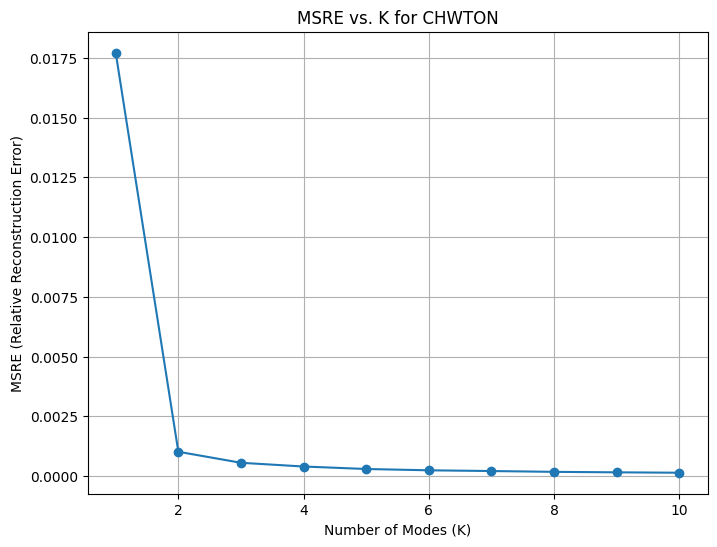

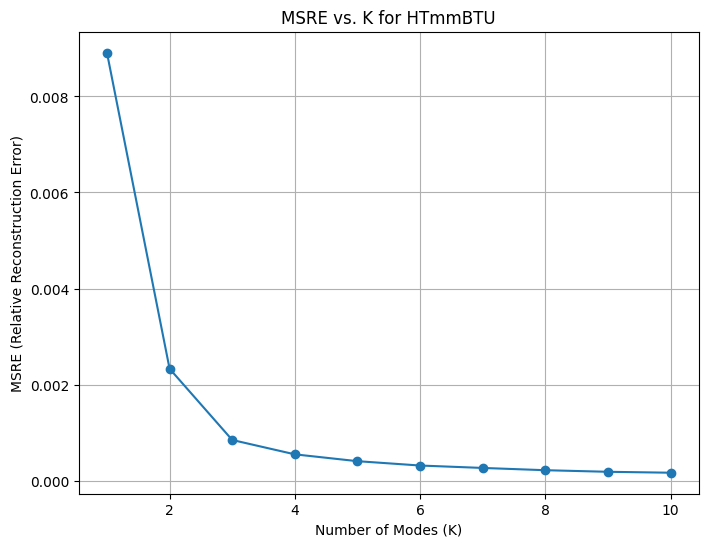

In [85]:
# 1. Compute MSRE for Each Load Type at Different K Values and Plot Results
for target in target_vars:
    if target in df.columns:
        signal = df[target].dropna().values
        msre_list = compute_msre_for_signal(signal, K_values, alpha, tau, DC, init, tol)
        plt.figure(figsize=(8,6))
        plt.plot(list(K_values), msre_list, marker='o', linestyle='-')
        plt.xlabel("Number of Modes (K)")
        plt.ylabel("MSRE (Relative Reconstruction Error)")
        plt.title(f"MSRE vs. K for {target}")
        plt.grid(True)
        plt.show()

## **4.4 Choose high-frequency IMF for each**

**VMD Decomposition Results for Electric Load (KW)**
* Mode 1 (Low-Frequency Component, Main Trend)
  * Represents the primary trend of the load data, showing long-term variations in electric load. Strongly correlated with seasonal changes.
* Mode 2 (Mid-Frequency Component, Major Fluctuations)
  * Fluctuation amplitude increases over time. Related to changes in daytime/nighttime electricity usage patterns and differences between weekdays and weekends.
* Mode 3 (High-Frequency Component, Short-Term Variations)
  * Smaller amplitude but exhibits rapid fluctuations. Associated with intermittent industrial equipment operation, especially HVAC (Heating, Ventilation, and Air Conditioning) system switching.
* Mode 4 (Ultra-High-Frequency Component, Possible Noise)
  * Nearly random high-frequency oscillations, representing noise or anomalous variations.

**VMD Decomposition of Heating Load (HTmmBTU)**
* Mode 1 (Low-Frequency Component)
 * Describes long-term trends, representing seasonal variations. Higher heating demand in certain periods, likely during winter.
* Mode 2 (Mid-Frequency Component)
  * Contains larger fluctuations, with stronger variations in the early and late parts of the dataset. Related to the dynamic switching of heating equipment.
* Mode 3 (High-Frequency Component, Possible Noise)
  * High-frequency fluctuations with smaller overall amplitude than Mode 2. Possibly includes anomalies or random noise in heating equipment operations.

**VMD Decomposition of Cooling Load (CHWTON)**
* Mode 1 (Low-Frequency Component, Main Trend)
  * Seasonal trend: lower load in the early phase, increasing over time, and eventually decreasing. Reflects variations in cooling demand during summer, with peaks likely corresponding to the hottest months.
* Mode 2 (Mid-Frequency Component, Load Variation Characteristics)
  * Larger fluctuation amplitude, showing short-term dynamic changes in cooling load. Possibly related to variations in cooling demand between daytime and nighttime.
* Mode 3 (High-Frequency Component, Possible Noise)
  * Contains higher-frequency fluctuations with smaller amplitude than Mode 2. Likely caused by measurement errors or random variations, possibly reflecting anomalies due to extreme weather conditions.

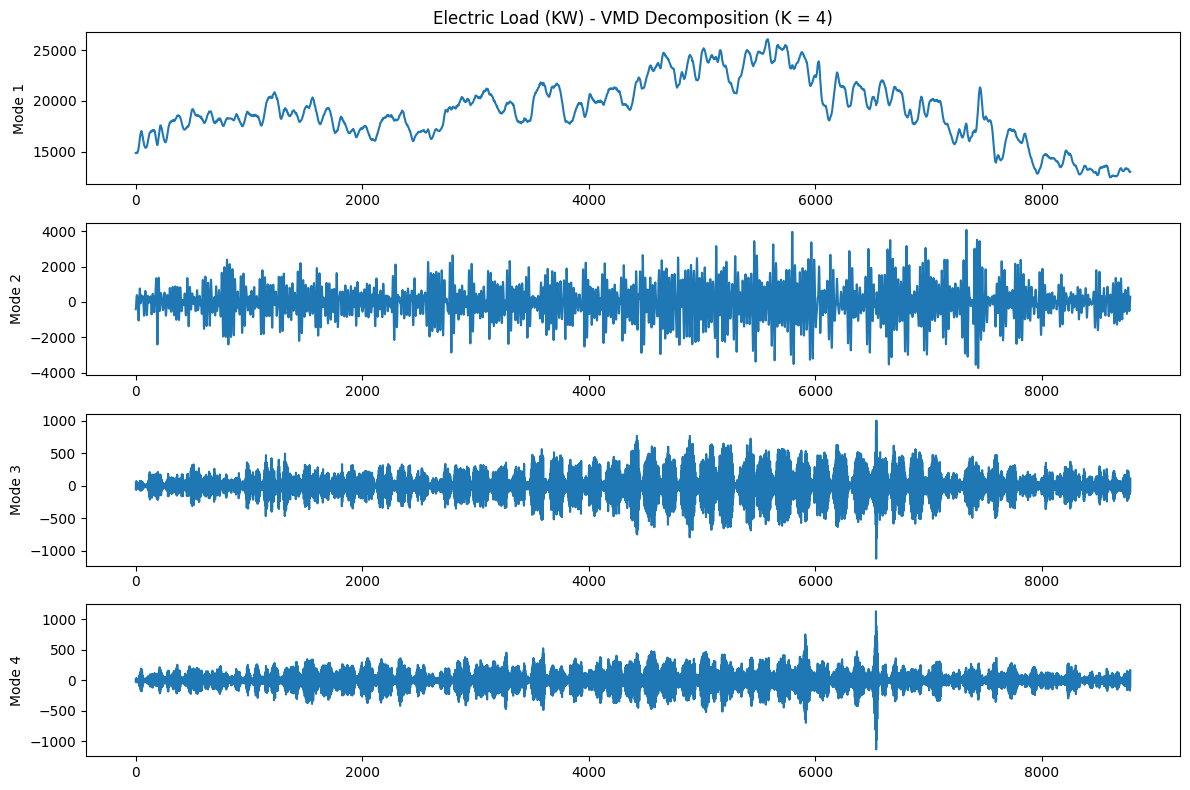

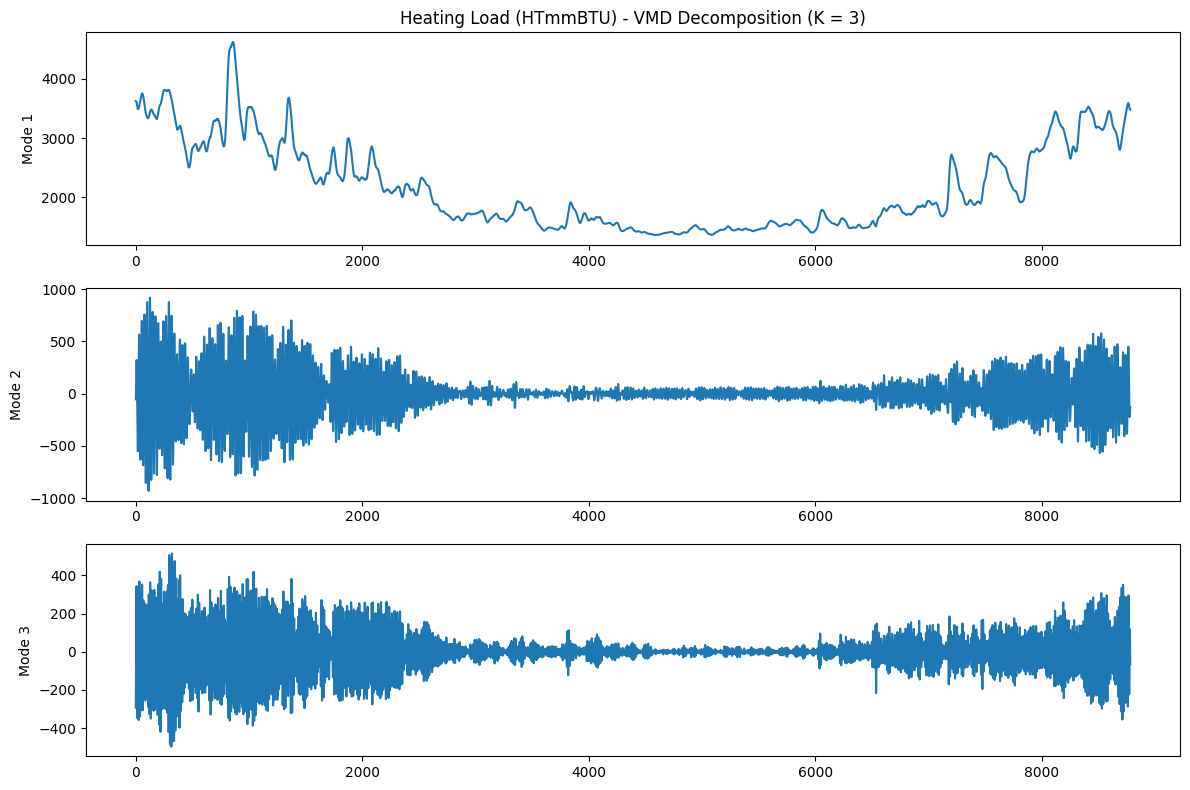

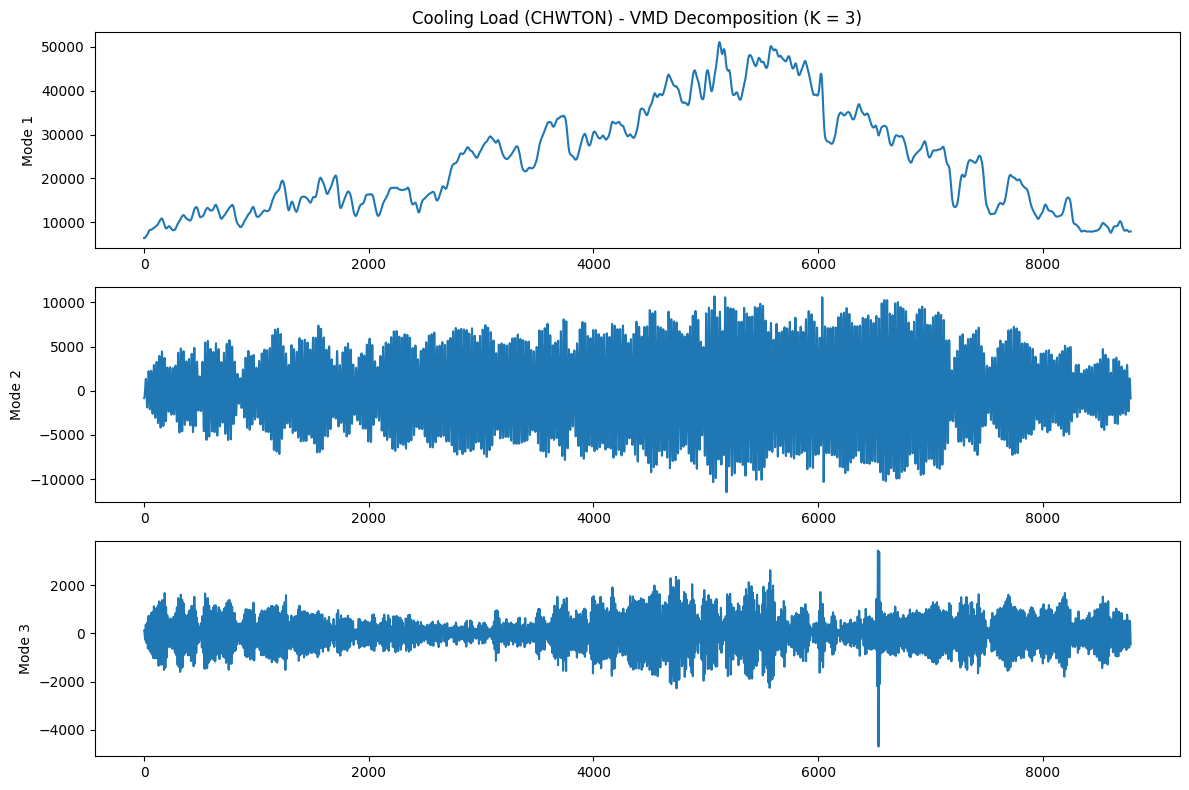

In [86]:
# Copy DataFrame and Perform VMD Decomposition for Each Load Type

df_vmd = df.copy()

# Set the number of modes for each load type (can be adjusted based on the MSRE analysis above)
K_elec = 4      # Number of modes for electric load
K_heating = 3   # Number of modes for thermal load
K_cooling = 3   # Number of modes for chilled load


# Electric Load (KW)
if 'KW' in df_vmd.columns:
    signal_elec = df_vmd['KW'].dropna().values
    u_elec, u_hat_elec, omega_elec = perform_and_plot_vmd(signal_elec, "Electric Load (KW)", K_elec)
    elec_index = df_vmd['KW'].dropna().index
    for i in range(K_elec):
        df_vmd.loc[elec_index, f"KW_VMD_{i+1}"] = u_elec[i, :]
    df_vmd.drop(columns=['KW'], inplace=True)


# Heating Load (HTmmBTU)
if 'HTmmBTU' in df_vmd.columns:
    signal_thermal = df_vmd['HTmmBTU'].dropna().values
    u_thermal, u_hat_thermal, omega_thermal = perform_and_plot_vmd(signal_thermal, "Heating Load (HTmmBTU)", K_heating)
    thermal_index = df_vmd['HTmmBTU'].dropna().index
    # Use the minimum between K_heating and the actual number of modes returned
    for i in range(min(K_heating, u_thermal.shape[0])):
        df_vmd.loc[thermal_index, f"HTmmBTU_VMD_{i+1}"] = u_thermal[i, :]
    df_vmd.drop(columns=['HTmmBTU'], inplace=True)


# Cooling Load (CHWTON)
if 'CHWTON' in df_vmd.columns:
    signal_chilled = df_vmd['CHWTON'].dropna().values
    u_chilled, u_hat_chilled, omega_chilled = perform_and_plot_vmd(signal_chilled, "Cooling Load (CHWTON)", K_cooling)
    chilled_index = df_vmd['CHWTON'].dropna().index
    for i in range(min(K_cooling, u_chilled.shape[0])):
        df_vmd.loc[chilled_index, f"CHWTON_VMD_{i+1}"] = u_chilled[i, :]
    df_vmd.drop(columns=['CHWTON'], inplace=True)



## **Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions (70 points)**

* For different load types (electric, heating, cooling), analysis is performed. First, by using Variational Mode Decomposition (VMD) to extract the high-frequency Intrinsic Mode Functions (IMF), and then merging these with other external influencing factors (such as temperature, humidity, wind speed, etc.), three comprehensive datasets are established. This approach can capture the local fluctuations in the load signals as well as the interactions with external environmental variables, providing rich feature information for subsequent unsupervised learning modeling.
  1. KMeans Clustering with PCA Visualization
  2. Hierarchical Clustering and Anomaly Detection
    * Hierarchical Clustering is employed to group the data, and anomalies are defined based on the Euclidean distance between samples within a group and the group centroid. This method not only reveals the inherent hierarchical structure of the data but also helps to detect data points that deviate significantly.
  3. SVD-based Anomaly Detection and Optimal Dimension Selection
    * Singular Value Decomposition (SVD) is used for dimensionality reduction to identify the primary structures within the data, and reconstruction error is used to detect anomalies. Simultaneously, the optimal reduced dimension is chosen based on the cumulative explained variance, ensuring that most of the information is retained after dimensionality reduction.
* Anomaly Detection Effectiveness:
  * By comparing the number of anomalous samples detected using different methods (Hierarchical Clustering vs. SVD), one can observe the sensitivity of each approach to extreme data points. Graphical displays (such as histograms of reconstruction errors and time series plots with marked anomalies) allow a clear visualization of the distribution of anomalous samples, which can aid in further processing based on business needs.

## **5. Analysis**

### **Feature Extraction and Combination**
* The high-frequency components of each load were extracted from the Variational Mode Decomposition (VMD) results, as anomalies are most detectable in the high-frequency range.
For each load type, appropriate additional features, such as meteorological conditions and temporal factors, were selected and combined with high-frequency load features to form a new dataset.
* The following additional features were chosen based on a correlation coefficient greater than 0.1 in previous analysis:
  * extra_features_KW = ['Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction']
  * extra_features_CHWTON = ['Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction', 'Wind_Speed']
  * extra_features_HTmmBTU = ['Relative_Humidity', 'Solar_Zenith_Angle', 'Pressure']



In [ ]:
# Extract high-frequency IMF for each load type (assumed to be the last mode)

hf_elec = df_vmd[f"KW_VMD_{K_elec}"]
hf_heating = df_vmd[f"HTmmBTU_VMD_{K_heating}"]
hf_cooling = df_vmd[f"CHWTON_VMD_{K_cooling}"]


# Define the extra features to be combined with VMD features

extra_features = ['Wind_Direction', 'Dew_Point', 'Surface_Albedo', 'Pressure',
                  'Wind_Speed', 'HTmmBTU', 'Hour', 'Relative_Humidity',
                  'Solar_Zenith_Angle', 'Month', 'Precipitable_Water', 'Temperature']

extra_features_KW = ['Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction']
extra_features_CHWTON = ['Temperature', 'Dew_Point', 'Surface_Albedo', 'Precipitable_Water', 'Wind_Direction', 'Wind_Speed']
extra_features_HTmmBTU = ['Relative_Humidity', 'Solar_Zenith_Angle', 'Pressure']


# Create separate combined datasets for each load type
# Electric load: combine high-frequency electric load feature with extra features
df_elec_combined = pd.concat([hf_elec, df[extra_features_KW]], axis=1).dropna()
df_elec_combined.rename(columns={hf_elec.name: 'KW_HF'}, inplace=True)
print("Electric Load combined dataset shape:", df_elec_combined.shape)

# heating load: combine high-frequency thermal load feature with extra features
df_heating_combined = pd.concat([hf_heating, df[extra_features_HTmmBTU]], axis=1).dropna()
df_heating_combined.rename(columns={hf_heating.name: 'HTmmBTU_HF'}, inplace=True)
print("Heating Load combined dataset shape:", df_heating_combined.shape)

# cooling load: combine high-frequency chilled load feature with extra features
df_cooling_combined = pd.concat([hf_cooling, df[extra_features_CHWTON]], axis=1).dropna()
df_cooling_combined.rename(columns={hf_cooling.name: 'CHWTON_HF'}, inplace=True)
print("Cooling Load combined dataset shape:", df_cooling_combined.shape)

### **Clustering Analysis and Visualization**
* After standardizing the data, KMeans clustering was applied to explore the impact of different cluster numbers on load classification.
PCA (Principal Component Analysis) was then used to reduce the data to 2D for visualization, helping to understand the cluster distribution of different load types.
* The original dataset contains over 8,000 hourly load records. After transforming the data into VMD signals, it primarily represents the time-series relationship.Thus, each data point reflects the relationship between hourly signals and relevant influencing factors.
    1. Electric Load:
      * The data points are divided into three main clusters. The purple cluster is denser, indicating that most electric load conditions are concentrated in a specific range. The yellow and green clusters are positioned at opposite ends, possibly corresponding to high-load and low-load patterns.
    2. Heating Load:
      * The overall distribution shows some overlap, indicating that certain heating load characteristics are similar. The purple cluster is more dispersed, which may be influenced by temperature, humidity, and other environmental factors. The yellow and green clusters occupy more concentrated regions, representing relatively stable heating load patterns.
    3. Cooling Load:
      * Three clusters are clearly separated in PCA space. The purple cluster covers a larger area, possibly representing high cooling demand. The distinction between the purple and green clusters suggests that the model effectively differentiates between different cooling load patterns.

* All three load types indicate that high loads are most susceptible to environmental factors.

Electric Load combined dataset shape: (8784, 6)
Heating Load combined dataset shape: (8784, 4)
Cooling Load combined dataset shape: (8784, 7)

--- Electric Load Clustering ---

=== KMeans with 3 clusters for Electric Load ===
Cluster Distribution:
Cluster
0    4148
2    2798
1    1838
Name: count, dtype: int64


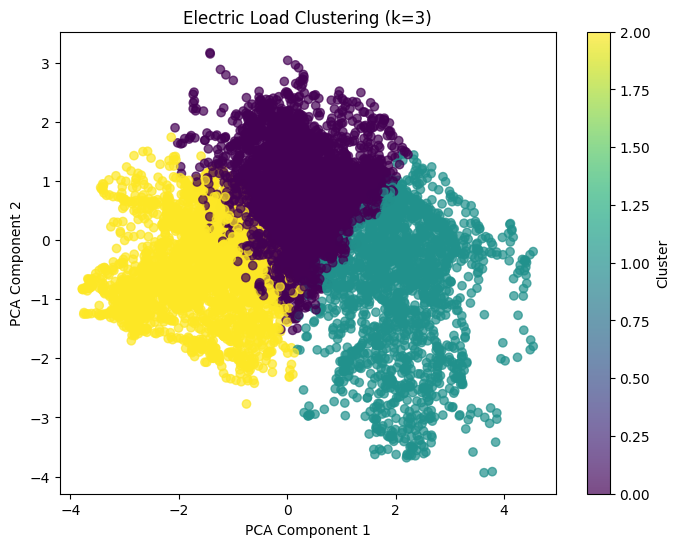


--- Thermal Load Clustering ---

=== KMeans with 3 clusters for Heating Load ===
Cluster Distribution:
Cluster
0    4150
1    2889
2    1745
Name: count, dtype: int64


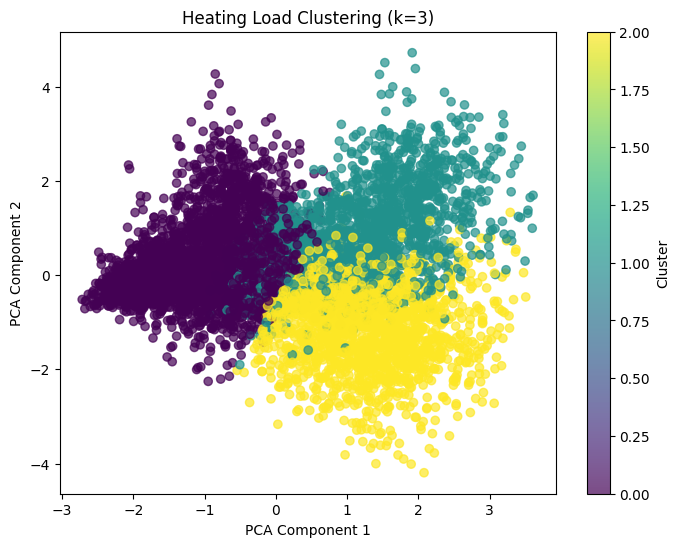


--- Chilled Load Clustering ---

=== KMeans with 3 clusters for Cooling Load ===
Cluster Distribution:
Cluster
1    4061
2    2868
0    1855
Name: count, dtype: int64


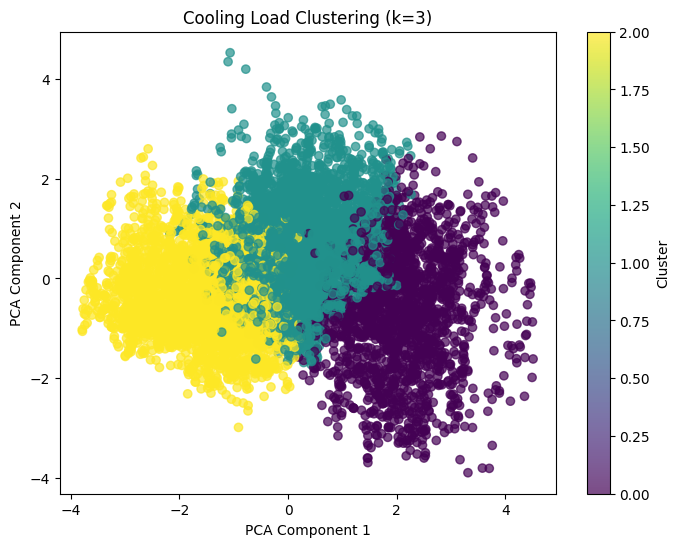

In [87]:
def cluster_and_visualize(df_data, label, cluster_numbers):
    scaler = StandardScaler()
    X = scaler.fit_transform(df_data)

    for k in cluster_numbers:
        print(f"\n=== KMeans with {k} clusters for {label} ===")
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X)
        df_data['Cluster'] = clusters  # temporary assignment

        print("Cluster Distribution:")
        print(df_data['Cluster'].value_counts())

        # Use PCA for visualization (2D)
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X)

        plt.figure(figsize=(8,6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title(f"{label} Clustering (k={k})")
        plt.colorbar(label="Cluster")
        plt.show()


# Perform clustering for each load type using cluster numbers 3,4,5,6

cluster_list = [3]

print("\n--- Electric Load Clustering ---")
cluster_and_visualize(df_elec_combined.copy(), "Electric Load", cluster_list)

print("\n--- Thermal Load Clustering ---")
cluster_and_visualize(df_heating_combined.copy(), "Heating Load", cluster_list)

print("\n--- Chilled Load Clustering ---")
cluster_and_visualize(df_cooling_combined.copy(), "Cooling Load", cluster_list)

### **Define Hierarchical Clustering ,SVD and Anomaly Detection**
1. **Hierarchical Clustering**
  * Perform hierarchical clustering and identify anomalies based on the distance between data points and their cluster centers.
    1. Compute hierarchical clustering using **Ward’s method** (minimizing within-cluster variance) and **Euclidean distance**.
    2. Cut the dendrogram at a set distance threshold and assign cluster labels to the data.
  * Anomaly Detection
    * Set the anomaly threshold as follows:

      **Threshold=Mean Distance+3×Standard Deviation**

    * Data points are marked as anomalies (True) if their distance exceeds the threshold or if the original data had missing values.

2. **SVD (Singular Value Decomposition) and Anomaly Detection**
  * Based on the set variance threshold (default is 0.9, i.e., 90%), the minimum number of components required to reach this cumulative explained variance (optimal_k) is determined.
  * SVD Dimensionality Reduction and Reconstruction
    * Using the optimal number of components (optimal_k), SVD is performed again on the data X, reducing the data to optimal_k dimensions. For each sample, the Euclidean distance between the original data and the reconstructed data is computed, which serves as the reconstruction error.
  * Anomaly Detection
    * Set the anomaly threshold as follows:

      **Threshold=Mean Distance+3×Standard Deviation**

    * Data points are marked as anomalies (True) if their distance exceeds the threshold or if the original data had missing values.

In [118]:
def hierarchical_clustering_with_anomaly(df, feature_cols, cluster_col, distance_col, anomaly_col, max_d=50):
    # Prepare multidimensional data without dropping missing values,
    #    while recording which rows contain missing values.
    df_sub = df[feature_cols]
    mask_missing = df_sub.isnull().any(axis=1)

    # Fill missing values (e.g., using the mean of each column)
    df_sub_imputed = df_sub.fillna(df_sub.mean())
    X = df_sub_imputed.values  # shape: (n_samples, n_features)

    # Perform hierarchical clustering (Ward's method with Euclidean distance)
    Z = sch.linkage(X, method='ward', metric='euclidean')

    # Cut the dendrogram at the specified distance to obtain cluster labels
    clusters = fcluster(Z, max_d, criterion='distance')
    df.loc[df_sub.index, cluster_col] = clusters

    # Calculate the center (mean) of each cluster (multidimensional average)
    cluster_centers = {}
    unique_clusters = np.unique(clusters)
    for c in unique_clusters:
        X_cluster = X[clusters == c]
        center_c = X_cluster.mean(axis=0)
        cluster_centers[c] = center_c

    # Compute the Euclidean distance from each sample to its cluster center
    distances = []
    for i, idx in enumerate(df_sub.index):
        c = clusters[i]
        x = X[i]
        center_c = cluster_centers[c]
        dist = np.linalg.norm(x - center_c, 2)
        distances.append(dist)
    df.loc[df_sub.index, distance_col] = distances

    # Set the anomaly threshold (mean + 3 * standard deviation)
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    threshold = mean_dist + 3 * std_dist

    # Mark anomalies: if the distance exceeds the threshold or the original data had missing values,
    #    mark it as an anomaly.
    anomalies = np.array([d > threshold or mask_missing.loc[idx] for d, idx in zip(distances, df_sub.index)], dtype=bool)
    df.loc[df_sub.index, anomaly_col] = anomalies

    return Z

def svd_optimal_dim_anomaly_detection(X, variance_threshold=0.9):

    n_features = X.shape[1]
    # First, perform SVD using all possible components
    svd_full = TruncatedSVD(n_components=n_features, random_state=42)
    X_full = svd_full.fit_transform(X)
    cumulative_variance = np.cumsum(svd_full.explained_variance_ratio_)
    # Find the minimum number of components such that the cumulative explained variance meets the threshold
    optimal_k = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"Optimal number of components selected: {optimal_k}")
    print("Cumulative Explained Variance:", cumulative_variance[:optimal_k])

    # Perform SVD dimensionality reduction using the optimal number of components
    svd_opt = TruncatedSVD(n_components=optimal_k, random_state=42)
    X_opt = svd_opt.fit_transform(X)
    # Reconstruct the data
    X_recon = svd_opt.inverse_transform(X_opt)
    # Compute the reconstruction error (Euclidean distance for each sample)
    errors = np.linalg.norm(X - X_recon, axis=1)
    # Define the anomaly threshold: mean error + 3*std
    threshold = np.mean(errors) + 3 * np.std(errors)
    anomalies = errors > threshold
    return X_opt, errors, threshold, anomalies, optimal_k, svd_opt, cumulative_variance

def svd_anomaly_detection(df, feature_cols, load_col, k=1):

    scaler = StandardScaler()
    X = scaler.fit_transform(df[feature_cols])

    # SVD decomposition
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Reconstruct using the first k components
    s_k = np.zeros_like(s)
    s_k[:k] = s[:k]
    X_reconstructed = (U * s_k) @ Vt

    # Compute the reconstruction error (Euclidean distance for each sample)
    errors = np.linalg.norm(X - X_reconstructed, axis=1)

    # Define anomaly threshold: mean error + 3 * standard deviation
    threshold = errors.mean() + 3 * errors.std()

    anomalies = errors > threshold
    df['SVD_Anomaly'] = anomalies

    return df, errors, threshold


### **Hierarchical Clustering v.s Singular Value Decomposition (SVD)**
Since in the visualization process we project multidimensional data onto a two-dimensional plane, points that appear to be outliers in the plot are not necessarily true anomalies. To detect anomalies more accurately, we employed both Hierarchical Clustering and Singular Value Decomposition (SVD) methods. The following shows the comparison of the anomaly counts detected by the two methods for different load types:

1. Electric Load
* SVD anomaly count: 68
* Hierarchical Clustering anomaly count: 69
2. Heating Load
* SVD anomaly count: 51
* Hierarchical Clustering anomaly count: 80
3. Cooling Load
* SVD anomaly count: 29
* Hierarchical Clustering anomaly count: 82

In this case, Hierarchical Clustering appears to be more suitable. This may be due to the analysis based on high-frequency IMF components, where there is inherently more noise. This noise might cause SVD to have difficulty in distinguishing anomalies, whereas Hierarchical Clustering performs better.

Electric Load SVD Anomaly Count: 39
Electric Load Hierarchical Clustering Anomaly Count: 69
Heating Load SVD Anomaly Count: 76
Heating Load Hierarchical Clustering Anomaly Count: 82
Cooling Load SVD Anomaly Count: 50
Cooling Load Hierarchical Clustering Anomaly Count: 80


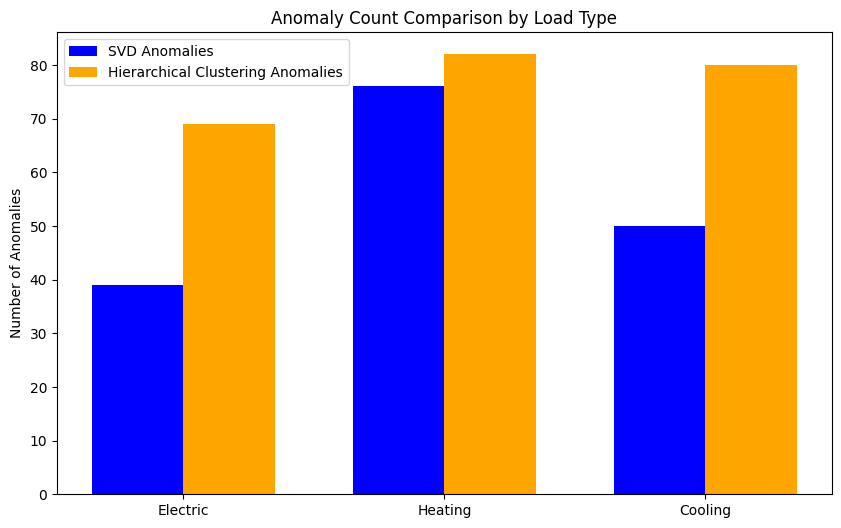

In [124]:
# Define feature lists for each load type
electric_features = ['KW_HF'] + extra_features_KW
heating_features  = ['HTmmBTU_HF'] + extra_features_HTmmBTU
cooling_features  = ['CHWTON_HF'] + extra_features_CHWTON

# Electric Load SVD anomaly detection (using k=1 as an example)
df_elec_combined, elec_errors, elec_threshold = svd_anomaly_detection(df_elec_combined, electric_features, 'KW_HF', k=4)
svd_elec_count = df_elec_combined['SVD_Anomaly'].sum()
hier_elec_count = df_elec_combined['Elec_Anomaly'].sum() if 'Elec_Anomaly' in df_elec_combined.columns else np.nan

print("Electric Load SVD Anomaly Count:", svd_elec_count)
print("Electric Load Hierarchical Clustering Anomaly Count:", hier_elec_count)

# Heating Load SVD anomaly detection
df_heating_combined, heating_errors, heating_threshold = svd_anomaly_detection(df_heating_combined, heating_features, 'HTmmBTU_HF', k=4)
svd_heating_count = df_heating_combined['SVD_Anomaly'].sum()
hier_heating_count = df_heating_combined['heating_Anomaly'].sum() if 'heating_Anomaly' in df_heating_combined.columns else np.nan

print("Heating Load SVD Anomaly Count:", svd_heating_count)
print("Heating Load Hierarchical Clustering Anomaly Count:", hier_heating_count)

# Cooling Load SVD anomaly detection
df_cooling_combined, cooling_errors, cooling_threshold = svd_anomaly_detection(df_cooling_combined, cooling_features, 'CHWTON_HF', k=4)
svd_cooling_count = df_cooling_combined['SVD_Anomaly'].sum()
hier_cooling_count = df_cooling_combined['Cooling_Anomaly'].sum() if 'Cooling_Anomaly' in df_cooling_combined.columns else np.nan

print("Cooling Load SVD Anomaly Count:", svd_cooling_count)
print("Cooling Load Hierarchical Clustering Anomaly Count:", hier_cooling_count)

# Graphical Comparison: Bar chart of anomaly counts for each load type
load_types = ['Electric', 'Heating', 'Cooling']
svd_counts = [svd_elec_count, svd_heating_count, svd_cooling_count]
hier_counts = [hier_elec_count, hier_heating_count, hier_cooling_count]

x = np.arange(len(load_types))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, svd_counts, width, label='SVD Anomalies', color='blue')
plt.bar(x + width/2, hier_counts, width, label='Hierarchical Clustering Anomalies', color='orange')
plt.xticks(x, load_types)
plt.ylabel('Number of Anomalies')
plt.title('Anomaly Count Comparison by Load Type')
plt.legend()
plt.show()


# **Detected Anomalies (Hierarchical Clustering)**

* High-Frequency Electric Load:
  * The blue line represents the "high-frequency load signal" obtained after extracting the high-frequency component via VMD and combining it with external features.
  * External factors such as weather (extra_features_KW) are incorporated as input features for the model.
  * The red scatter points indicate the "anomalies" that were detected based on training using the combined features of high-frequency load (KW_HF) and weather factors.
  * The fact that multiple anomaly points for the electric load appear vertically suggests that these points likely represent issues occurring within a few hours in the equipment.

* High-Frequency Heating Load:
  * Samples marked as anomalies are typically those that are relatively far from the center of their cluster or lie in extreme positions such as peaks or troughs.
  * These anomalies may correspond to issues in the boiler system, heat exchangers, or pipelines, or they may be caused by weather-related factors leading to abnormal load conditions.
  * Most of the anomalies tend to occur within a few hours, and notably, during winter, the increased equipment load makes anomalies more likely.
  * That year, the heating equipment was quite old, and Taiwan’s winter humidity was relatively high, especially in the northern region, with an average relative humidity of about 70% to 90%. Machine rust often leads to momentary anomalies.
  * When a cold front passes, atmospheric pressure may temporarily drop. Since the large heating equipment is placed outdoors with poor sealing performance, this also contributes to load anomalies.

* High-Frequency Cooling Load
  * In applications such as air-conditioning or chilled water systems, these anomalies may indicate unstable operation of cooling units, equipment failures, sensor malfunctions, or other external factors.
  * The correlation between refrigeration equipment and electrical load is high, and the distribution does not show as pronounced seasonality as seen with heating loads. This is because, aside from increased usage during the summer, many environments within factories require cooling to maintain production equipment or server rooms at suitable temperatures.
  * Taiwan's climate, with its high humidity and large temperature differences, is also one of the factors affecting the load.

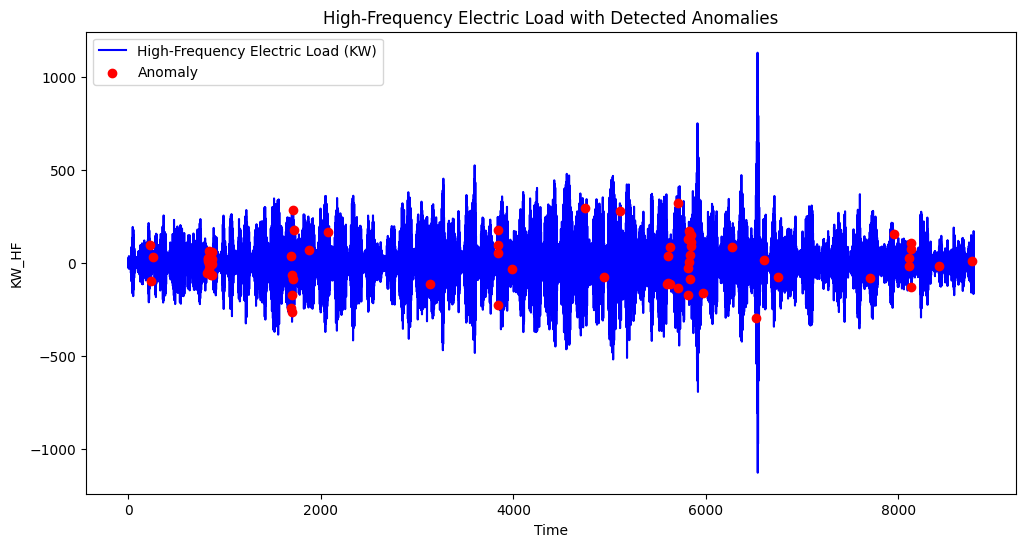

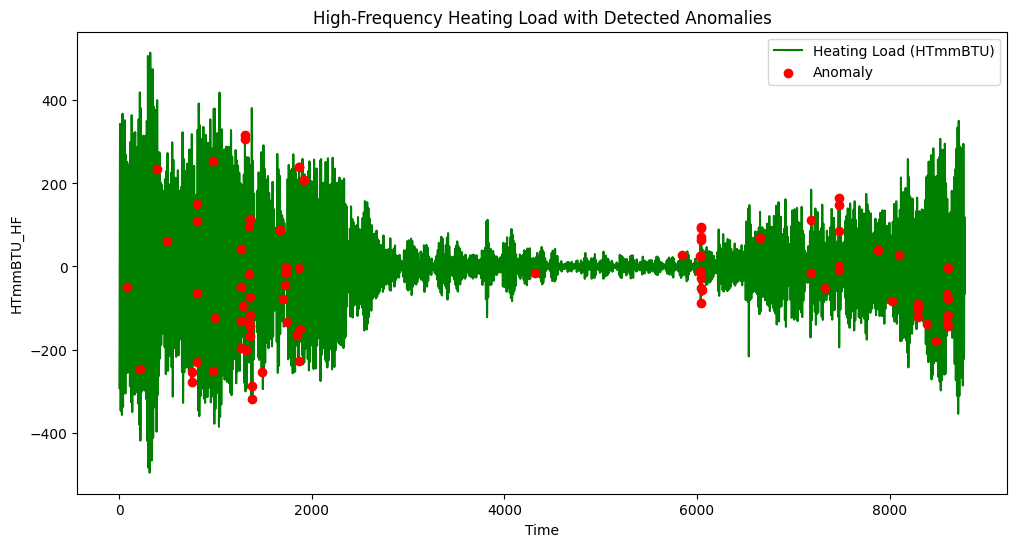

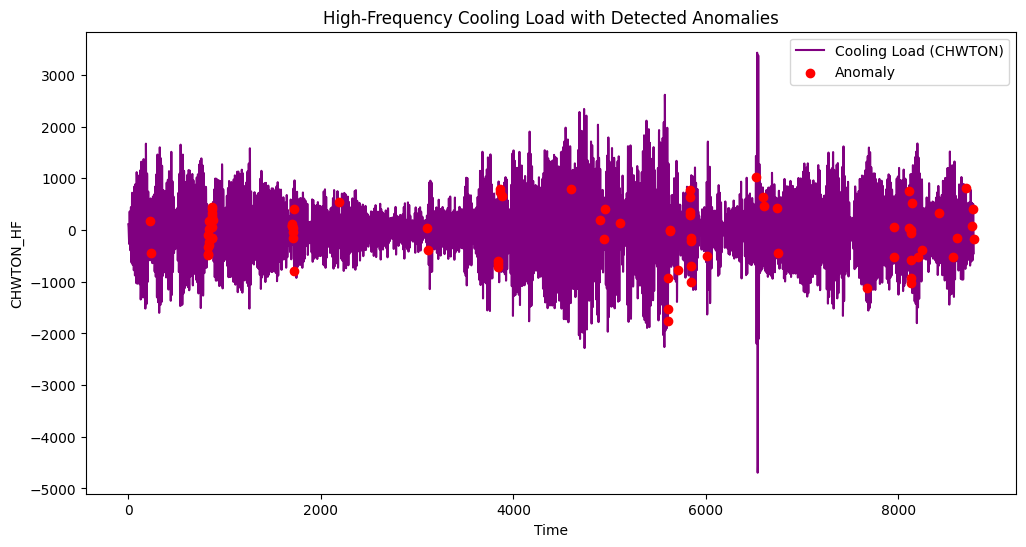

In [108]:
# Perform hierarchical clustering + anomaly detection (using df_elec_combined)
Z_elec = hierarchical_clustering_with_anomaly(
    df=df_elec_combined,
    feature_cols=extra_features_KW,
    cluster_col='Elec_Cluster_Hier',       # Column to store cluster labels
    distance_col='Elec_Distance',          # Column to store distances
    anomaly_col='Elec_Anomaly',            # Column to store anomaly flag
    max_d=50
)

plt.figure(figsize=(12,6))
plt.plot(df_elec_combined['KW_HF'], label='High-Frequency Electric Load (KW)', color='blue')
# Mark anomalies: red scatter points
electric_anomalies = df_elec_combined[df_elec_combined['Elec_Anomaly'] == True]
plt.scatter(electric_anomalies.index, electric_anomalies['KW_HF'], color='red', label='Anomaly', zorder=5)
plt.xlabel('Time')
plt.ylabel('KW_HF')
plt.title('High-Frequency Electric Load with Detected Anomalies')
plt.legend()
plt.show()


# Perform hierarchical clustering + anomaly detection (for Heating Load)
Z_thermal = hierarchical_clustering_with_anomaly(
    df=df_heating_combined,
    feature_cols=extra_features_HTmmBTU,  # Use extra_features_HTmmBTU for heating load
    cluster_col='heating_Cluster_Hier',
    distance_col='heating_Distance',
    anomaly_col='heating_Anomaly',
    max_d=50
)

# Plotting: use the 'HTmmBTU_HF' column from df_heating_combined
plt.figure(figsize=(12,6))
plt.plot(df_heating_combined['HTmmBTU_HF'], label='Heating Load (HTmmBTU)', color='green')

# Mark anomalies (red scatter points) based on the clustering results
thermal_anomalies = df_heating_combined[df_heating_combined['heating_Anomaly'] == True]
plt.scatter(thermal_anomalies.index, thermal_anomalies['HTmmBTU_HF'], color='red', label='Anomaly', zorder=5)

plt.xlabel('Time')
plt.ylabel('HTmmBTU_HF')
plt.title('High-Frequency Heating Load with Detected Anomalies')
plt.legend()
plt.show()

# Perform hierarchical clustering + anomaly detection (for Cooling Load)
Z_cooling = hierarchical_clustering_with_anomaly(
    df=df_cooling_combined,                          # Use df_cooling_combined
    feature_cols=extra_features_CHWTON,              # For cooling load, extra_features_HTmmBTU is used during merging
    cluster_col='Cooling_Cluster_Hier',             # Column to store cluster labels
    distance_col='Cooling_Distance',                # Column to store distances
    anomaly_col='Cooling_Anomaly',                  # Column to store anomaly flag
    max_d=50
)


# Plotting: use the 'CHWTON_HF' column from df_cooling_combined
plt.figure(figsize=(12,6))
plt.plot(df_cooling_combined['CHWTON_HF'], label='Cooling Load (CHWTON)', color='purple')

# Mark anomalies (red scatter points) based on the anomaly flag from clustering results
cooling_anomalies = df_cooling_combined[df_cooling_combined['Cooling_Anomaly'] == True]
plt.scatter(cooling_anomalies.index, cooling_anomalies['CHWTON_HF'], color='red', label='Anomaly', zorder=5)

plt.xlabel('Time')
plt.ylabel('CHWTON_HF')
plt.title('High-Frequency Cooling Load with Detected Anomalies')
plt.legend()
plt.show()


# **Detected Anomalies (SVD)**
  * SVD is often more sensitive in capturing extreme spikes or drops, as it uses reconstruction error to detect samples that deviate from the main data structure. This makes it particularly responsive to instantaneous extreme changes, though sometimes it may overlook sustained deviations over longer periods.
  1. Electric Load Anomaly Detection:
    * Sudden spikes or valleys often indicate potential equipment issues or emergent events that require prompt response.
  2. Heating Load Anomaly Detection:
    * It is capable of capturing those sudden, distinctly abnormal heating load data points that deviate markedly from the group pattern, which helps in early warning of equipment malfunctions or abrupt climatic changes.
  3. Cooling Load Anomaly Detection:
    * It can quickly identify load fluctuations caused by environmental factors (such as cold fronts or brief drops in air pressure) or equipment malfunctions, which is crucial for system maintenance and early alerting.

Optimal number of components selected: 7
Cumulative Explained Variance: [0.27582369 0.43595252 0.56994462 0.67009071 0.76722524 0.85717705
 0.92484373]
Electric Load SVD Explained Variance Ratio: [0.27582369 0.16012883 0.1339921  0.10014609 0.09713452 0.08995182
 0.06766667]
Electric Load Anomaly Threshold: 1.9222119786583105


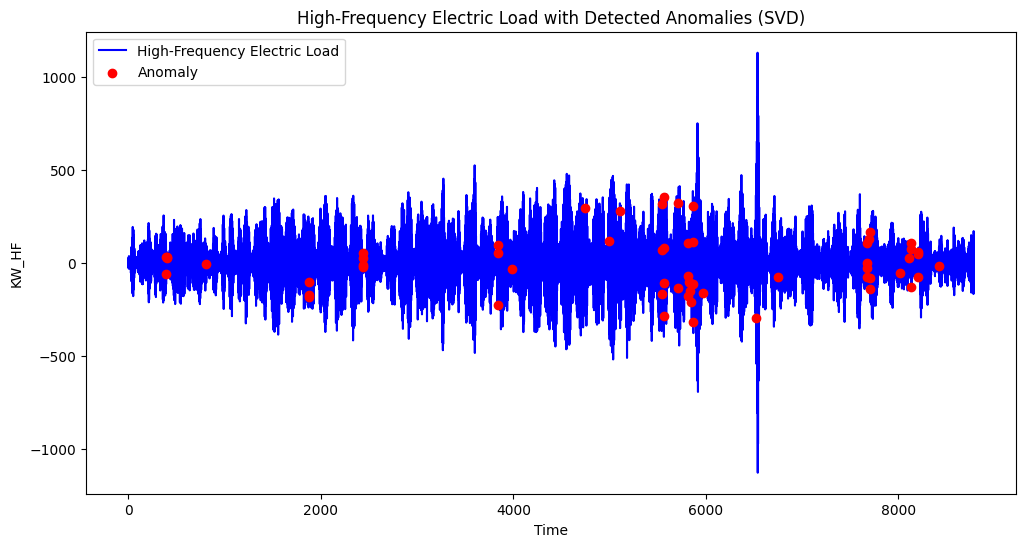

Optimal number of components selected: 6
Cumulative Explained Variance: [0.28644893 0.45644702 0.59273341 0.71784431 0.83103151 0.90847241]
Heating Load SVD Explained Variance Ratio: [0.28644893 0.16999808 0.1362864  0.1251109  0.11318719 0.0774409 ]
Heating Load Anomaly Threshold: 1.9962341730625326


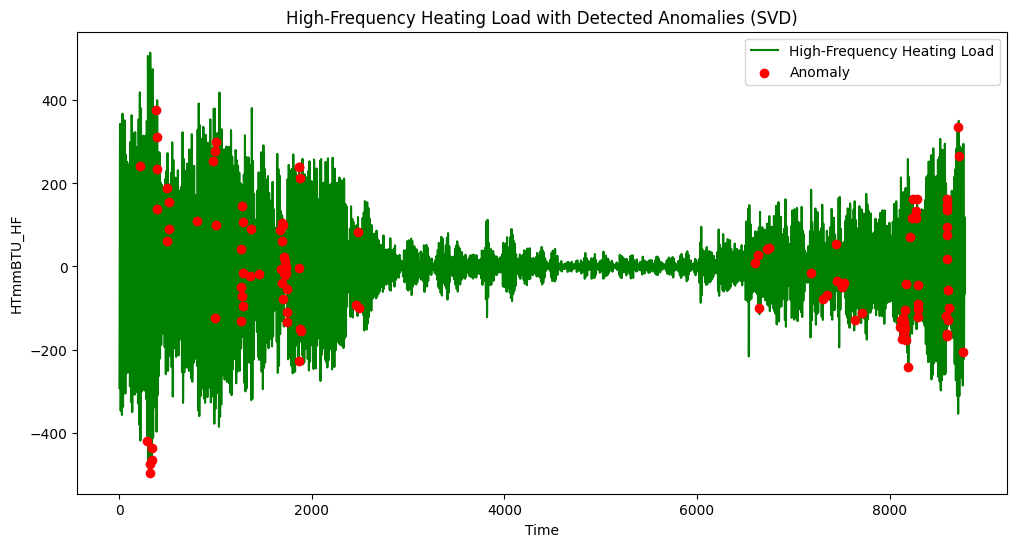

Cooling Load combined dataset shape: (8784, 11)
Optimal number of components selected: 8
Cumulative Explained Variance: [0.2516913  0.39921625 0.52612464 0.63644266 0.72682998 0.81438151
 0.88775394 0.94652862]
Cooling Load SVD Explained Variance Ratio: [0.2516913  0.14752495 0.1269084  0.11031802 0.09038732 0.08755153
 0.07337243 0.05877468]
Cooling Load Anomaly Threshold: 1.7077734364191086


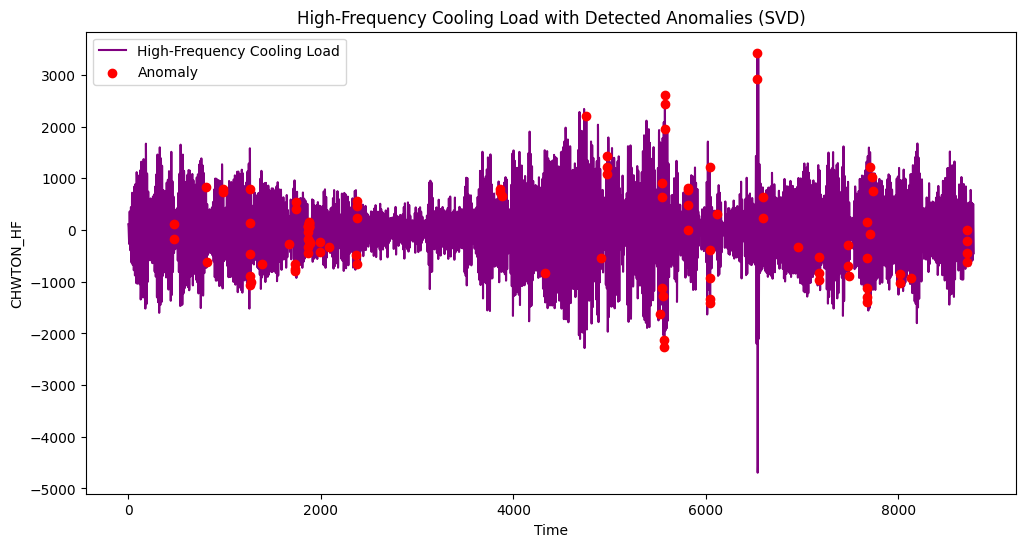

In [106]:
# Electric Load Processing

# Standardize the data
scaler_elec = StandardScaler()
X_elec = scaler_elec.fit_transform(df_elec_combined)

# Use SVD with optimal dimension selection for anomaly detection
X_elec_svd, errors_elec, threshold_elec, anomalies_elec, optimal_k_elec, svd_elec, cum_var_elec = svd_optimal_dim_anomaly_detection(X_elec, variance_threshold=0.9)

print("Electric Load SVD Explained Variance Ratio:", svd_elec.explained_variance_ratio_)
print("Electric Load Anomaly Threshold:", threshold_elec)

# Plot the high-frequency electric load signal and detected anomalies (overlaid on the original high-frequency signal)
plt.figure(figsize=(12,6))
plt.plot(df_elec_combined.index, df_elec_combined['KW_HF'], label='High-Frequency Electric Load', color='blue')
# Retrieve the anomaly indices based on the SVD anomaly detection results
anomaly_idx = df_elec_combined.index[anomalies_elec]
plt.scatter(anomaly_idx, df_elec_combined.loc[anomaly_idx, 'KW_HF'], color='red', label='Anomaly', zorder=5)

plt.xlabel('Time')
plt.ylabel('KW_HF')
plt.title('High-Frequency Electric Load with Detected Anomalies (SVD)')
plt.legend()
plt.show()



# Heating Load Processing

scaler_heating = StandardScaler()
X_heating = scaler_heating.fit_transform(df_heating_combined)

X_heating_svd, errors_heating, threshold_heating, anomalies_heating, optimal_k_heating, svd_heating, cum_var_heating = svd_optimal_dim_anomaly_detection(X_heating, variance_threshold=0.9)
print("Heating Load SVD Explained Variance Ratio:", svd_heating.explained_variance_ratio_)
print("Heating Load Anomaly Threshold:", threshold_heating)

plt.figure(figsize=(12,6))
plt.plot(df_heating_combined.index, df_heating_combined['HTmmBTU_HF'], label='High-Frequency Heating Load', color='green')
anomaly_idx = df_heating_combined.index[anomalies_heating]
plt.scatter(anomaly_idx, df_heating_combined.loc[anomaly_idx, 'HTmmBTU_HF'], color='red', label='Anomaly', zorder=5)
plt.xlabel('Time')
plt.ylabel('HTmmBTU_HF')
plt.title('High-Frequency Heating Load with Detected Anomalies (SVD)')
plt.legend()
plt.show()


# Cooling Load Processing
print("Cooling Load combined dataset shape:", df_cooling_combined.shape)

scaler_cooling = StandardScaler()
X_cooling = scaler_cooling.fit_transform(df_cooling_combined)

X_cooling_svd, errors_cooling, threshold_cooling, anomalies_cooling, optimal_k_cooling, svd_cooling, cum_var_cooling = svd_optimal_dim_anomaly_detection(X_cooling, variance_threshold=0.9)
print("Cooling Load SVD Explained Variance Ratio:", svd_cooling.explained_variance_ratio_)
print("Cooling Load Anomaly Threshold:", threshold_cooling)

plt.figure(figsize=(12,6))
plt.plot(df_cooling_combined.index, df_cooling_combined['CHWTON_HF'], label='High-Frequency Cooling Load', color='purple')
anomaly_idx = df_cooling_combined.index[anomalies_cooling]
plt.scatter(anomaly_idx, df_cooling_combined.loc[anomaly_idx, 'CHWTON_HF'], color='red', label='Anomaly', zorder=5)
plt.xlabel('Time')
plt.ylabel('CHWTON_HF')
plt.title('High-Frequency Cooling Load with Detected Anomalies (SVD)')
plt.legend()
plt.show()


# **6. Comprehensive Comparison and Detailed Explanation**
*  **Results Comparison:**
    * From the graphs, it can be observed that the anomalies detected by the two methods (Hierarchical Clustering and SVD) partially overlap in the Electric, Heating, and Cooling Loads, but each method also produces its own unique detection results.

    1. Electric Load:
      * Both Hierarchical Clustering and SVD are able to detect clear extreme points, but SVD is more likely to mark anomalies at sudden spikes or valleys occurring over short periods.

    2. Heating Load:
      * Due to the evident seasonal variations in equipment load, Hierarchical Clustering may mark anomalies based on the characteristics of the entire group, whereas SVD tends to respond more quickly to abrupt anomalies.

    3. Cooling Load:
      * Both methods can capture anomalies caused by environmental changes or unstable equipment operation. However, SVD better reflects single-instance extreme changes, while Hierarchical Clustering may group consecutive anomalies into the same cluster.

* Future Work:
  * It is regrettable that a complete mechanism is not yet in place; at the time, only records of several major equipment overhauls during the year were available, and micro-anomaly records were not maintained. Consequently, it is not possible to verify the accuracy of either method. However, it is clear that each method has its own strengths and weaknesses as seen in the graphs, and data collection will continue to be enhanced in the future.